# Baseline Correction

In this notebook, we will explore different baseline correction methods implemented in the spec_tools package. For this we will use the **baseline.py** module which contains the **Baseline** class. This class provides different methods for baseline correction and smoothing of the spectral data

In [1]:
import sys
sys.path.append('..')
import spec_tools

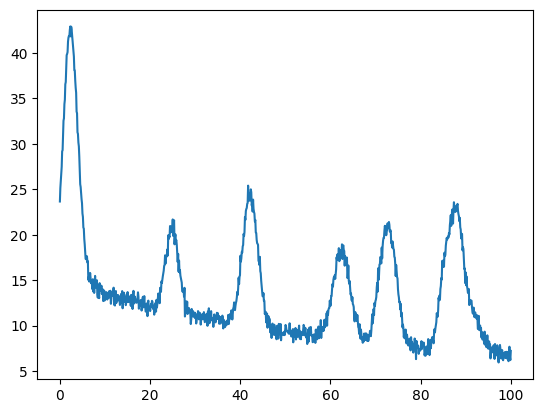

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#x,y = spec_tools.baseline.generate_random_gaussian_peaks(10,[0,100],noise_level=0.5)
x,y = spec_tools.baseline.generate_random_gaussian_with_shifted_baseline(10,[0,100],noise_level=0.5)

plt.plot(x,y)


In [3]:
# Next of we generate a Spectrum Object from the data
data = np.array([x,y]).T

spectrum = spec_tools.spectrum.Spectrum(name="Test-Data", data=data)

# Initialize the baseline class using this spectrum object

baseline1 = spec_tools.baseline.Baseline(spectrum)

# Smoothing of Noise Data

For this different approaches are implemented. The most common methods is applying a rolling average filter. This is done by the **apply_rolling_average_filter** method in the **Baseline** class.

> Note that the smoothed data gets safed in the baseline object. Thus in Jupyter executing the same code multiple times applies the filter multiple times.

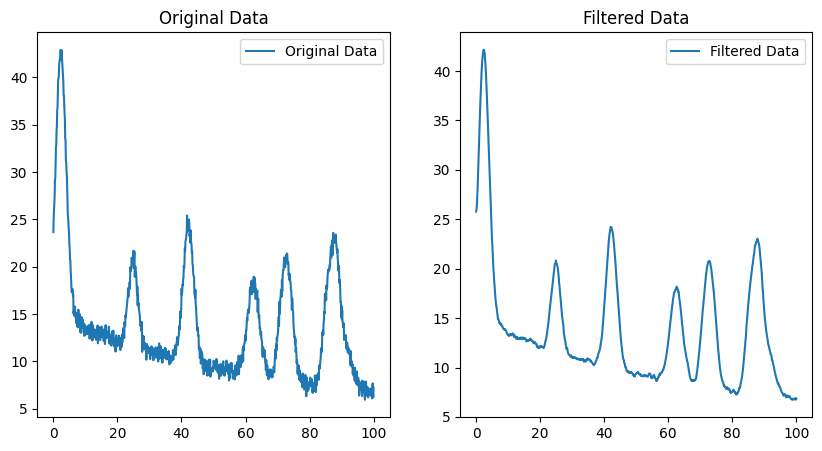

In [4]:
baseline1.apply_rolling_average_filter(window_size=10)

Another approach is to use a **Gaussian Filter**. Gaussian filters are often used in singal processing, the impuls response here is a Gaussian Function. Mathmatically this is done via convolution of a the data with a Gaussian Function.

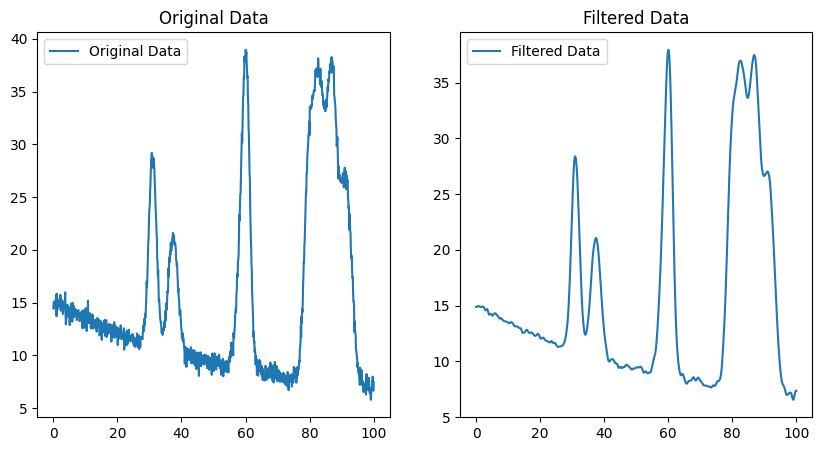

In [5]:
x1,y2 = spec_tools.baseline.generate_random_gaussian_with_shifted_baseline(10,[0,100],noise_level=0.5)
data2 = np.array([x1,y2]).T
spectrum2 = spec_tools.spectrum.Spectrum(name="Test-Data", data=data2)
baseline2 = spec_tools.baseline.Baseline(spectrum2)

baseline2.apply_gaussian_filter(sigma=3)

Another metod is to use a **Savitzky-Golay Filter**. This filter smooths the data by fitting successive sub-sets of adjacent data points with a low-degree polynomial with the method of linear-least squares. Advantage of this method is that it preserves the shape of the features such as peaks and valleys which might be lost with other smoothing methods

So we have a polynomial

\begin{equation}
y = a_0 + a_1 x + a_2 x^2 + ... + a_n x^n
\end{equation}

And minimize the squared differences between actual data points and the polynomial values

\begin{equation}
Minimize ~~ \sum_{i=-m}^{m} (y_{k+i}-\sum_{j=0}^{n} a_j x_{k+i}^j)^2
\end{equation}



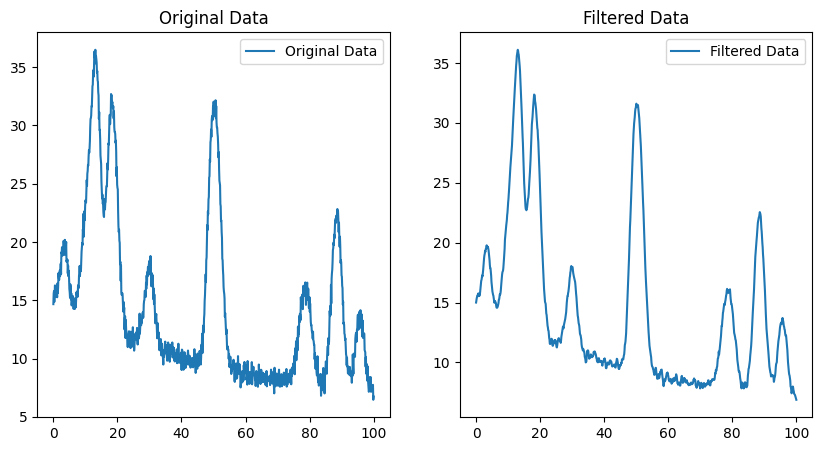

In [6]:
x3,y3 = spec_tools.baseline.generate_random_gaussian_with_shifted_baseline(10,[0,100],noise_level=0.5)
data3 = np.array([x3,y3]).T
spectrum3 = spec_tools.spectrum.Spectrum(name="Test-Data", data=data3)
baseline3 = spec_tools.baseline.Baseline(spectrum3)
baseline3.apply_savgol_filter(window_length=10)

# Polynomial Baseline Correction

A general polynomial has the form:

\begin{equation}
p(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + ... + \beta_n x^n = \sum_{i=0}^n \beta_i x^i
\end{equation}

where $\beta$ is the coefficient array of the polynomial. For polynomial fitting we use a least squares approach to minimize the residuals between the polynomial and the data.

\begin{equation}
\sum_{i=0}^n \left( y_i - p(x_i) \right)^2
\end{equation}

## Automated Selective Masking

For **Selective Masking** the goal is to remove the peaks from the data and keep only the raw baseline here we employ the following algorithm:

1. Pick the peaks using **scipy_signal.find_peaks** function
2. Fit a gaussian to the peaks to estimate the peak width
3. Add a error margin to the peak width
4. Create a mask of the data 
5. Fit a polynomial to the masked data

/home/lme/.conda/envs/molecular_m/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


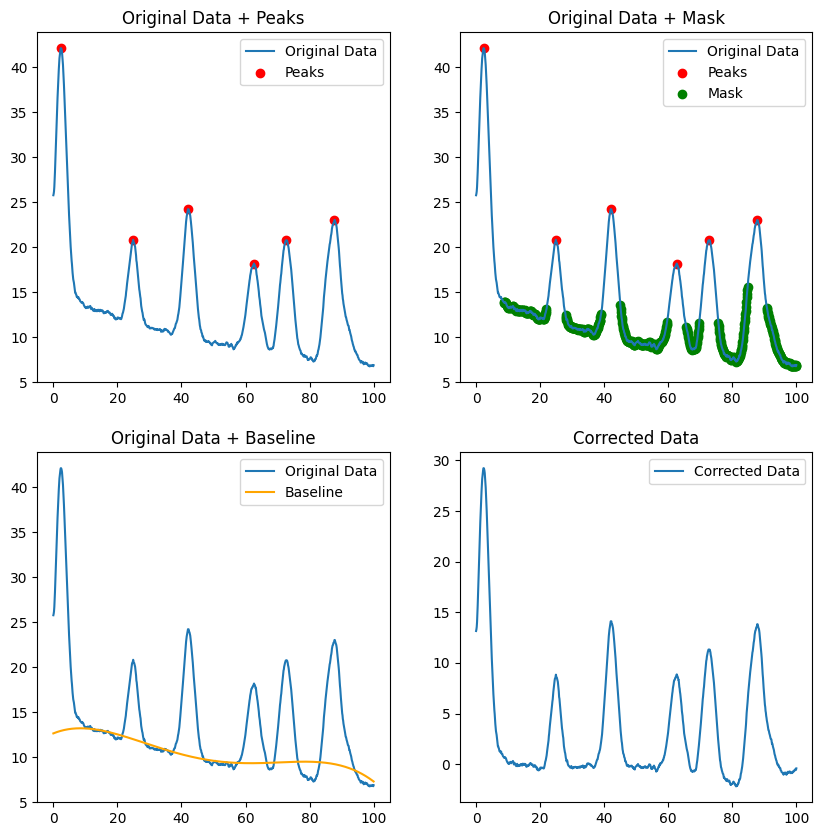

In [7]:
baseline1.selective_masking_poly_fit(peak_height=15.5,peak_distance=20,peak_width_guess=20,poly_order=4)